In [68]:
import shap
import optuna
from sklearn import set_config
from xgboost import XGBRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

## Dataset

In [2]:
set_config(transform_output="pandas") 

In [3]:
# load the data

data = fetch_california_housing(as_frame=True)

In [4]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [5]:
# make X and y

X, y = data.data, data.target

In [6]:
# columns names

feature_names = data.feature_names

feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [7]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [8]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [9]:
X.shape

(20640, 8)

In [10]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of Training data: ", X_train.shape)
print("Shape of Testing data: ", X_test.shape)

Shape of Training data:  (16512, 8)
Shape of Testing data:  (4128, 8)


## Model

In [11]:
# model 
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42,
                         n_jobs=-1, learning_rate=0.2, n_estimators=200,
                         reg_lambda=50, max_depth=7, gamma=0.05)

In [12]:
# fit the training data
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [13]:
# claculate the predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# calculate the RMSE and R2 score
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2899, R2: 0.9371
Test RMSE: 0.4474, R2: 0.8472


### HP Tuning

In [14]:
# tune the model

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
        'gamma': trial.suggest_float('gamma', 0, 2),
        "subsample": trial.suggest_float('subsample', 0.7, 1.0),
        "n_jobs": -1,
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    
    # set the model with the parameters
    model = XGBRegressor()
    
    model.set_params(**params)
    
    # fit the model
    model.fit(X_train, y_train)
    
    # predict the test data
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

In [15]:
# create a study
study = optuna.create_study(direction='maximize')

study.optimize(func=objective, n_trials=50, show_progress_bar=True, n_jobs=-1)

[I 2025-09-14 22:34:42,235] A new study created in memory with name: no-name-7841d4fe-7009-4546-bbc4-ad34651780e0
Best trial: 2. Best value: 0.815144:   2%|▏         | 1/50 [00:01<01:26,  1.77s/it]

[I 2025-09-14 22:34:44,126] Trial 2 finished with value: 0.8151435435121873 and parameters: {'learning_rate': 0.18136518785720868, 'n_estimators': 135, 'max_depth': 5, 'reg_lambda': 78.70461555577589, 'gamma': 1.7672436538929193, 'subsample': 0.7070985569188891}. Best is trial 2 with value: 0.8151435435121873.


Best trial: 0. Best value: 0.821867:   4%|▍         | 2/50 [00:02<00:54,  1.14s/it]

[I 2025-09-14 22:34:44,830] Trial 0 finished with value: 0.8218665879955062 and parameters: {'learning_rate': 0.2556262790589916, 'n_estimators': 282, 'max_depth': 10, 'reg_lambda': 44.673751063850666, 'gamma': 1.505183154472849, 'subsample': 0.8715910627698302}. Best is trial 0 with value: 0.8218665879955062.


Best trial: 1. Best value: 0.82269:   6%|▌         | 3/50 [00:02<00:40,  1.17it/s] 

[I 2025-09-14 22:34:45,337] Trial 1 finished with value: 0.8226902336886697 and parameters: {'learning_rate': 0.28561647268808177, 'n_estimators': 386, 'max_depth': 10, 'reg_lambda': 72.45891259648118, 'gamma': 1.317013030812657, 'subsample': 0.9659815984640506}. Best is trial 1 with value: 0.8226902336886697.


Best trial: 3. Best value: 0.837207:   8%|▊         | 4/50 [00:04<00:55,  1.22s/it]

[I 2025-09-14 22:34:47,111] Trial 3 finished with value: 0.8372072337046332 and parameters: {'learning_rate': 0.2802037287117785, 'n_estimators': 448, 'max_depth': 3, 'reg_lambda': 49.547724380669884, 'gamma': 0.27506854470015907, 'subsample': 0.7707420894948791}. Best is trial 3 with value: 0.8372072337046332.


Best trial: 3. Best value: 0.837207:  10%|█         | 5/50 [00:04<00:38,  1.17it/s]

[I 2025-09-14 22:34:47,319] Trial 6 finished with value: 0.8207944866701616 and parameters: {'learning_rate': 0.27681436127761283, 'n_estimators': 325, 'max_depth': 9, 'reg_lambda': 24.615534286135418, 'gamma': 1.2860558300423401, 'subsample': 0.910763190811154}. Best is trial 3 with value: 0.8372072337046332.


Best trial: 5. Best value: 0.841365:  12%|█▏        | 6/50 [00:05<00:31,  1.38it/s]

[I 2025-09-14 22:34:47,792] Trial 5 finished with value: 0.8413653991848464 and parameters: {'learning_rate': 0.1588329242864994, 'n_estimators': 218, 'max_depth': 7, 'reg_lambda': 14.160035126003546, 'gamma': 0.5519044380914815, 'subsample': 0.7590212154748721}. Best is trial 5 with value: 0.8413653991848464.


Best trial: 5. Best value: 0.841365:  14%|█▍        | 7/50 [00:08<00:59,  1.38s/it]

[I 2025-09-14 22:34:50,516] Trial 4 finished with value: 0.8327020019461984 and parameters: {'learning_rate': 0.05532548330471747, 'n_estimators': 433, 'max_depth': 10, 'reg_lambda': 7.026986888972822, 'gamma': 0.992912110586291, 'subsample': 0.8142567809773766}. Best is trial 5 with value: 0.8413653991848464.


Best trial: 5. Best value: 0.841365:  16%|█▌        | 8/50 [00:08<00:42,  1.02s/it]

[I 2025-09-14 22:34:50,767] Trial 8 finished with value: 0.8207938178631954 and parameters: {'learning_rate': 0.19821810236361906, 'n_estimators': 247, 'max_depth': 10, 'reg_lambda': 63.82680340076875, 'gamma': 1.8291521586862665, 'subsample': 0.7784512475614089}. Best is trial 5 with value: 0.8413653991848464.


Best trial: 5. Best value: 0.841365:  18%|█▊        | 9/50 [00:09<00:41,  1.01s/it]

[I 2025-09-14 22:34:51,772] Trial 7 finished with value: 0.8281321883917556 and parameters: {'learning_rate': 0.2621212022451237, 'n_estimators': 331, 'max_depth': 4, 'reg_lambda': 94.55169375852762, 'gamma': 0.9177246551068332, 'subsample': 0.7075062187316777}. Best is trial 5 with value: 0.8413653991848464.


Best trial: 5. Best value: 0.841365:  20%|██        | 10/50 [00:10<00:41,  1.03s/it]

[I 2025-09-14 22:34:52,849] Trial 10 finished with value: 0.8236846706638511 and parameters: {'learning_rate': 0.1986816006492284, 'n_estimators': 211, 'max_depth': 6, 'reg_lambda': 68.74546525977162, 'gamma': 0.9071600211711663, 'subsample': 0.99163813938039}. Best is trial 5 with value: 0.8413653991848464.


Best trial: 5. Best value: 0.841365:  22%|██▏       | 11/50 [00:10<00:33,  1.17it/s]

[I 2025-09-14 22:34:53,300] Trial 9 finished with value: 0.813971888983908 and parameters: {'learning_rate': 0.07931417365005874, 'n_estimators': 378, 'max_depth': 3, 'reg_lambda': 32.923141805132545, 'gamma': 0.5869289346476236, 'subsample': 0.7930136680193312}. Best is trial 5 with value: 0.8413653991848464.


Best trial: 5. Best value: 0.841365:  24%|██▍       | 12/50 [00:11<00:30,  1.25it/s]

[I 2025-09-14 22:34:53,975] Trial 12 finished with value: 0.8295279082868077 and parameters: {'learning_rate': 0.14123902969675042, 'n_estimators': 175, 'max_depth': 6, 'reg_lambda': 10.070686522242422, 'gamma': 0.7314771293352225, 'subsample': 0.9755013927093794}. Best is trial 5 with value: 0.8413653991848464.


Best trial: 5. Best value: 0.841365:  26%|██▌       | 13/50 [00:13<00:45,  1.23s/it]

[I 2025-09-14 22:34:56,181] Trial 13 finished with value: 0.8336378663870949 and parameters: {'learning_rate': 0.10186258825438749, 'n_estimators': 79, 'max_depth': 8, 'reg_lambda': 1.3528114160476914, 'gamma': 0.019978638323860487, 'subsample': 0.7566497381312608}. Best is trial 5 with value: 0.8413653991848464.
[I 2025-09-14 22:34:56,270] Trial 15 finished with value: 0.48185676208098227 and parameters: {'learning_rate': 0.0122389246799392, 'n_estimators': 54, 'max_depth': 8, 'reg_lambda': 48.405468104733224, 'gamma': 0.06848732451844441, 'subsample': 0.7497964199372759}. Best is trial 5 with value: 0.8413653991848464.


Best trial: 17. Best value: 0.843817:  30%|███       | 15/50 [00:19<01:10,  2.01s/it]

[I 2025-09-14 22:35:02,022] Trial 17 finished with value: 0.8438165531845276 and parameters: {'learning_rate': 0.23245714830326686, 'n_estimators': 482, 'max_depth': 7, 'reg_lambda': 19.046424239627697, 'gamma': 0.2987542369883016, 'subsample': 0.8438448716151107}. Best is trial 17 with value: 0.8438165531845276.


Best trial: 11. Best value: 0.850811:  32%|███▏      | 16/50 [00:20<00:57,  1.70s/it]

[I 2025-09-14 22:35:02,771] Trial 11 finished with value: 0.8508106027646344 and parameters: {'learning_rate': 0.0727449957991253, 'n_estimators': 295, 'max_depth': 9, 'reg_lambda': 95.86640943677307, 'gamma': 0.04139826728870033, 'subsample': 0.9131202987559277}. Best is trial 11 with value: 0.8508106027646344.


Best trial: 11. Best value: 0.850811:  34%|███▍      | 17/50 [00:24<01:17,  2.35s/it]

[I 2025-09-14 22:35:06,943] Trial 18 finished with value: 0.842890252488849 and parameters: {'learning_rate': 0.22616596309874254, 'n_estimators': 484, 'max_depth': 7, 'reg_lambda': 23.04833798944921, 'gamma': 0.4174499752915809, 'subsample': 0.8470957520841624}. Best is trial 11 with value: 0.8508106027646344.


Best trial: 11. Best value: 0.850811:  36%|███▌      | 18/50 [00:25<00:58,  1.83s/it]

[I 2025-09-14 22:35:07,386] Trial 14 finished with value: 0.8468195959690122 and parameters: {'learning_rate': 0.13259777746108134, 'n_estimators': 493, 'max_depth': 7, 'reg_lambda': 4.563259102475902, 'gamma': 0.01791785889677122, 'subsample': 0.7603246437771114}. Best is trial 11 with value: 0.8508106027646344.


Best trial: 11. Best value: 0.850811:  38%|███▊      | 19/50 [00:25<00:48,  1.57s/it]

[I 2025-09-14 22:35:08,297] Trial 19 finished with value: 0.8475760373287184 and parameters: {'learning_rate': 0.23548266308027205, 'n_estimators': 500, 'max_depth': 8, 'reg_lambda': 95.85908233846105, 'gamma': 0.3361871717655779, 'subsample': 0.895633878962047}. Best is trial 11 with value: 0.8508106027646344.


Best trial: 11. Best value: 0.850811:  40%|████      | 20/50 [00:27<00:46,  1.54s/it]

[I 2025-09-14 22:35:09,774] Trial 16 finished with value: 0.8127538905725906 and parameters: {'learning_rate': 0.011681114925691016, 'n_estimators': 482, 'max_depth': 7, 'reg_lambda': 48.14765247176867, 'gamma': 0.1420483515841925, 'subsample': 0.7474364361276921}. Best is trial 11 with value: 0.8508106027646344.


Best trial: 11. Best value: 0.850811:  42%|████▏     | 21/50 [00:31<01:07,  2.32s/it]

[I 2025-09-14 22:35:14,008] Trial 20 finished with value: 0.8484183185745052 and parameters: {'learning_rate': 0.12199942094586178, 'n_estimators': 495, 'max_depth': 8, 'reg_lambda': 93.09614674058109, 'gamma': 0.26908575734969986, 'subsample': 0.9202516040206231}. Best is trial 11 with value: 0.8508106027646344.


Best trial: 21. Best value: 0.851778:  44%|████▍     | 22/50 [00:32<00:53,  1.90s/it]

[I 2025-09-14 22:35:14,883] Trial 21 finished with value: 0.8517781545861216 and parameters: {'learning_rate': 0.12385760635008912, 'n_estimators': 393, 'max_depth': 8, 'reg_lambda': 98.3489260016457, 'gamma': 0.1751747534801847, 'subsample': 0.9220903386885453}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  46%|████▌     | 23/50 [00:34<00:48,  1.79s/it]

[I 2025-09-14 22:35:16,418] Trial 23 finished with value: 0.8341563667314766 and parameters: {'learning_rate': 0.05196048312923153, 'n_estimators': 384, 'max_depth': 9, 'reg_lambda': 96.75371447721206, 'gamma': 0.7061382634370088, 'subsample': 0.9208600643254998}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  48%|████▊     | 24/50 [00:37<01:02,  2.42s/it]

[I 2025-09-14 22:35:20,312] Trial 25 finished with value: 0.8410963480518396 and parameters: {'learning_rate': 0.10981586431415337, 'n_estimators': 388, 'max_depth': 9, 'reg_lambda': 86.6210793601029, 'gamma': 0.5151786586135627, 'subsample': 0.9243205033568418}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  50%|█████     | 25/50 [00:38<00:46,  1.87s/it]

[I 2025-09-14 22:35:20,907] Trial 22 finished with value: 0.839016080854507 and parameters: {'learning_rate': 0.02612097570158403, 'n_estimators': 391, 'max_depth': 9, 'reg_lambda': 97.8072988512971, 'gamma': 0.23560511440761495, 'subsample': 0.9253607791937959}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  52%|█████▏    | 26/50 [00:39<00:36,  1.50s/it]

[I 2025-09-14 22:35:21,536] Trial 24 finished with value: 0.8441708572514831 and parameters: {'learning_rate': 0.08666082942542633, 'n_estimators': 405, 'max_depth': 9, 'reg_lambda': 99.74855373395205, 'gamma': 0.34734309002448455, 'subsample': 0.9251112851181679}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  54%|█████▍    | 27/50 [00:41<00:41,  1.79s/it]

[I 2025-09-14 22:35:24,007] Trial 26 finished with value: 0.8484256255794902 and parameters: {'learning_rate': 0.1153734551970772, 'n_estimators': 426, 'max_depth': 9, 'reg_lambda': 83.39941029889815, 'gamma': 0.20969069048498384, 'subsample': 0.9532872429211181}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  56%|█████▌    | 28/50 [00:45<00:51,  2.34s/it]

[I 2025-09-14 22:35:27,647] Trial 28 finished with value: 0.8493651044345297 and parameters: {'learning_rate': 0.10842005214148269, 'n_estimators': 314, 'max_depth': 8, 'reg_lambda': 84.67949920475925, 'gamma': 0.1803277604785596, 'subsample': 0.9534859509426252}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  58%|█████▊    | 29/50 [00:45<00:36,  1.73s/it]

[I 2025-09-14 22:35:27,925] Trial 27 finished with value: 0.8507184964498006 and parameters: {'learning_rate': 0.10768291366558866, 'n_estimators': 327, 'max_depth': 8, 'reg_lambda': 85.44093886605003, 'gamma': 0.17267855691261438, 'subsample': 0.9419861899852617}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  60%|██████    | 30/50 [00:46<00:28,  1.42s/it]

[I 2025-09-14 22:35:28,615] Trial 29 finished with value: 0.848974994705473 and parameters: {'learning_rate': 0.1183453842471816, 'n_estimators': 331, 'max_depth': 8, 'reg_lambda': 85.94789264157443, 'gamma': 0.16269582639562813, 'subsample': 0.9510930585721945}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  62%|██████▏   | 31/50 [00:48<00:29,  1.56s/it]

[I 2025-09-14 22:35:30,497] Trial 30 finished with value: 0.8496027859762114 and parameters: {'learning_rate': 0.15642107422809667, 'n_estimators': 337, 'max_depth': 8, 'reg_lambda': 86.55878228291746, 'gamma': 0.15055736193221209, 'subsample': 0.9553300450917124}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  64%|██████▍   | 32/50 [00:49<00:26,  1.46s/it]

[I 2025-09-14 22:35:31,731] Trial 32 finished with value: 0.8113442125429303 and parameters: {'learning_rate': 0.06769621937817709, 'n_estimators': 289, 'max_depth': 6, 'reg_lambda': 57.850710221859046, 'gamma': 1.9844557274482297, 'subsample': 0.8732726308890446}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  66%|██████▌   | 33/50 [00:51<00:29,  1.75s/it]

[I 2025-09-14 22:35:34,154] Trial 31 finished with value: 0.8335831369237683 and parameters: {'learning_rate': 0.06759880517914701, 'n_estimators': 334, 'max_depth': 8, 'reg_lambda': 58.88438834325428, 'gamma': 0.7475244204961441, 'subsample': 0.8852358741213164}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  68%|██████▊   | 34/50 [00:52<00:23,  1.45s/it]

[I 2025-09-14 22:35:34,899] Trial 33 finished with value: 0.8305311309160008 and parameters: {'learning_rate': 0.05844019713423505, 'n_estimators': 287, 'max_depth': 6, 'reg_lambda': 61.35787978985934, 'gamma': 0.7133405834012538, 'subsample': 0.8728458804516426}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  70%|███████   | 35/50 [00:53<00:18,  1.23s/it]

[I 2025-09-14 22:35:35,627] Trial 34 finished with value: 0.8410695759793517 and parameters: {'learning_rate': 0.16571443549374287, 'n_estimators': 286, 'max_depth': 6, 'reg_lambda': 75.67238223520415, 'gamma': 0.4422042470399281, 'subsample': 0.8793429334144767}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  72%|███████▏  | 36/50 [00:55<00:20,  1.47s/it]

[I 2025-09-14 22:35:37,660] Trial 36 finished with value: 0.8199322428879683 and parameters: {'learning_rate': 0.16395394226566432, 'n_estimators': 278, 'max_depth': 10, 'reg_lambda': 74.03345011869074, 'gamma': 1.4833255364084978, 'subsample': 0.9982424468363584}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  74%|███████▍  | 37/50 [00:56<00:18,  1.40s/it]

[I 2025-09-14 22:35:38,877] Trial 35 finished with value: 0.8437447405606657 and parameters: {'learning_rate': 0.15917323611865525, 'n_estimators': 352, 'max_depth': 10, 'reg_lambda': 76.11841308030294, 'gamma': 0.4075795705134376, 'subsample': 0.8841135237271086}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  76%|███████▌  | 38/50 [00:57<00:16,  1.36s/it]

[I 2025-09-14 22:35:40,174] Trial 37 finished with value: 0.8235863429594473 and parameters: {'learning_rate': 0.16178897727787125, 'n_estimators': 362, 'max_depth': 10, 'reg_lambda': 75.33166930436165, 'gamma': 1.2316942875465409, 'subsample': 0.9764944895012706}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  78%|███████▊  | 39/50 [00:58<00:11,  1.06s/it]

[I 2025-09-14 22:35:40,511] Trial 38 finished with value: 0.8217030322593243 and parameters: {'learning_rate': 0.1465955137029362, 'n_estimators': 358, 'max_depth': 10, 'reg_lambda': 90.21801067369394, 'gamma': 1.4158917512660953, 'subsample': 0.9993001158071643}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  80%|████████  | 40/50 [01:00<00:14,  1.48s/it]

[I 2025-09-14 22:35:42,995] Trial 40 finished with value: 0.817434014088255 and parameters: {'learning_rate': 0.09214606183033783, 'n_estimators': 249, 'max_depth': 5, 'reg_lambda': 90.0419335737151, 'gamma': 1.1424842121020622, 'subsample': 0.9402802514169514}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  84%|████████▍ | 42/50 [01:03<00:10,  1.26s/it]

[I 2025-09-14 22:35:45,348] Trial 39 finished with value: 0.8488213016177546 and parameters: {'learning_rate': 0.14588828191029923, 'n_estimators': 248, 'max_depth': 10, 'reg_lambda': 89.72938642947366, 'gamma': 0.1354530369111136, 'subsample': 0.9697460593568387}. Best is trial 21 with value: 0.8517781545861216.
[I 2025-09-14 22:35:45,446] Trial 42 finished with value: 0.8366198147427513 and parameters: {'learning_rate': 0.0906280350682542, 'n_estimators': 246, 'max_depth': 5, 'reg_lambda': 37.090854707807395, 'gamma': 0.08188405281530696, 'subsample': 0.940401169544894}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  86%|████████▌ | 43/50 [01:07<00:15,  2.17s/it]

[I 2025-09-14 22:35:49,766] Trial 41 finished with value: 0.8503756612887141 and parameters: {'learning_rate': 0.0933945589067058, 'n_estimators': 261, 'max_depth': 9, 'reg_lambda': 90.22174236239591, 'gamma': 0.10534177448519796, 'subsample': 0.9442886601746103}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  88%|████████▊ | 44/50 [01:08<00:10,  1.70s/it]

[I 2025-09-14 22:35:50,381] Trial 43 finished with value: 0.8490669490046684 and parameters: {'learning_rate': 0.18592257161027964, 'n_estimators': 309, 'max_depth': 9, 'reg_lambda': 81.03233823226527, 'gamma': 0.12021813838792642, 'subsample': 0.9043212504891216}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  90%|█████████ | 45/50 [01:10<00:10,  2.01s/it]

[I 2025-09-14 22:35:53,108] Trial 44 finished with value: 0.8499419688424981 and parameters: {'learning_rate': 0.18448040862914622, 'n_estimators': 296, 'max_depth': 8, 'reg_lambda': 80.77296159400562, 'gamma': 0.10010407898868878, 'subsample': 0.9443516257990442}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  92%|█████████▏| 46/50 [01:14<00:09,  2.47s/it]

[I 2025-09-14 22:35:56,643] Trial 45 finished with value: 0.8392702126498043 and parameters: {'learning_rate': 0.039636094305132236, 'n_estimators': 311, 'max_depth': 8, 'reg_lambda': 81.36643119591494, 'gamma': 0.1964542703330777, 'subsample': 0.8983934759825734}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  94%|█████████▍| 47/50 [01:17<00:08,  2.78s/it]

[I 2025-09-14 22:36:00,145] Trial 47 finished with value: 0.8324607796835082 and parameters: {'learning_rate': 0.03869253453353649, 'n_estimators': 208, 'max_depth': 9, 'reg_lambda': 68.56105079607963, 'gamma': 0.025330158818081264, 'subsample': 0.94439772400876}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  96%|█████████▌| 48/50 [01:18<00:04,  2.24s/it]

[I 2025-09-14 22:36:01,120] Trial 48 finished with value: 0.8314732958803404 and parameters: {'learning_rate': 0.03714823698230579, 'n_estimators': 214, 'max_depth': 9, 'reg_lambda': 68.97238123254544, 'gamma': 0.5238052355486554, 'subsample': 0.9380084005589132}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778:  98%|█████████▊| 49/50 [01:19<00:01,  1.83s/it]

[I 2025-09-14 22:36:01,998] Trial 49 finished with value: 0.8385840184882607 and parameters: {'learning_rate': 0.075507617940167, 'n_estimators': 198, 'max_depth': 9, 'reg_lambda': 93.14823528927215, 'gamma': 0.5935012836101521, 'subsample': 0.829884931589952}. Best is trial 21 with value: 0.8517781545861216.


Best trial: 21. Best value: 0.851778: 100%|██████████| 50/50 [01:20<00:00,  1.61s/it]

[I 2025-09-14 22:36:02,747] Trial 46 finished with value: 0.8442700209190444 and parameters: {'learning_rate': 0.041552592841349816, 'n_estimators': 309, 'max_depth': 9, 'reg_lambda': 80.73414565212613, 'gamma': 0.011113894497218734, 'subsample': 0.9013231428608536}. Best is trial 21 with value: 0.8517781545861216.


In [16]:
# get the best parameters
study.best_params

{'learning_rate': 0.12385760635008912,
 'n_estimators': 393,
 'max_depth': 8,
 'reg_lambda': 98.3489260016457,
 'gamma': 0.1751747534801847,
 'subsample': 0.9220903386885453}

In [17]:
# get the best value
study.best_value

0.8517781545861216

In [18]:
# get the best estimator
best_model = XGBRegressor(**study.best_params)

best_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [19]:
# print the metrics
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.3074, R2: 0.9293
Test RMSE: 0.4475, R2: 0.8472


## SHAP

In [20]:
best_model

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [21]:
# create the tree explainer

explainer = shap.TreeExplainer(model=best_model,
                               data=X_train)

In [22]:
# expected value
explainer.expected_value

np.float64(2.0069155999652457)

In [23]:
# calculate the shap values for all test data

shap_values = explainer(X_test)

 99%|===================| 4098/4128 [02:03<00:00]        

In [24]:
shap_values.shape

(4128, 8)

In [25]:
len(feature_names)

8

In [26]:
feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [27]:
shap_values[0:5]

.values =
array([[-0.38287614,  0.00823297, -0.10890289,  0.00743682, -0.026297  ,
        -0.21892914, -0.6966287 , -0.04955633],
       [-0.29873071,  0.01322193, -0.07930888,  0.03119741,  0.00411879,
        -0.0096289 , -0.69259674,  0.05437369],
       [ 0.06961125,  0.37993814, -0.02463142,  0.06818588, -0.00375373,
         0.71657713,  0.22359704,  1.47240039],
       [ 0.45421127,  0.02163425,  0.16971978,  0.00543562,  0.00721925,
        -0.33255034,  0.19726665,  0.04530243],
       [-0.06384116, -0.00517457, -0.01693696,  0.01347303,  0.00278207,
         0.02082501, -0.41680554,  0.90431535]])

.base_values =
array([2.0069156, 2.0069156, 2.0069156, 2.0069156, 2.0069156])

.data =
array([[ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,
         1.02228412e+00,  1.39200000e+03,  3.87743733e+00,
         3.60600000e+01, -1.19010000e+02],
       [ 2.53130000e+00,  3.00000000e+01,  5.03938356e+00,
         1.19349315e+00,  1.56500000e+03,  2.67979452e+00,
         3.514000

In [28]:
X_test.head(1).values

array([[ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,
         1.02228412e+00,  1.39200000e+03,  3.87743733e+00,
         3.60600000e+01, -1.19010000e+02]])

### GLOBAL PLOTS

In [29]:
shap_values

.values =
array([[-0.38287614,  0.00823297, -0.10890289, ..., -0.21892914,
        -0.6966287 , -0.04955633],
       [-0.29873071,  0.01322193, -0.07930888, ..., -0.0096289 ,
        -0.69259674,  0.05437369],
       [ 0.06961125,  0.37993814, -0.02463142, ...,  0.71657713,
         0.22359704,  1.47240039],
       ...,
       [ 1.71084335, -0.03496276,  0.40001305, ...,  0.0095617 ,
        -0.02329341,  0.89346285],
       [-0.25664546, -0.03100608, -0.06172524, ...,  0.00905028,
        -0.97866729,  0.01550565],
       [-0.08376479, -0.03177626, -0.26487754, ..., -0.30637487,
         0.22632911,  0.05817257]], shape=(4128, 8))

.base_values =
array([2.0069156, 2.0069156, 2.0069156, ..., 2.0069156, 2.0069156,
       2.0069156], shape=(4128,))

.data =
array([[   1.6812    ,   25.        ,    4.19220056, ...,    3.87743733,
          36.06      , -119.01      ],
       [   2.5313    ,   30.        ,    5.03938356, ...,    2.67979452,
          35.14      , -119.46      ],
       [  

In [30]:
shap_values.shape

(4128, 8)

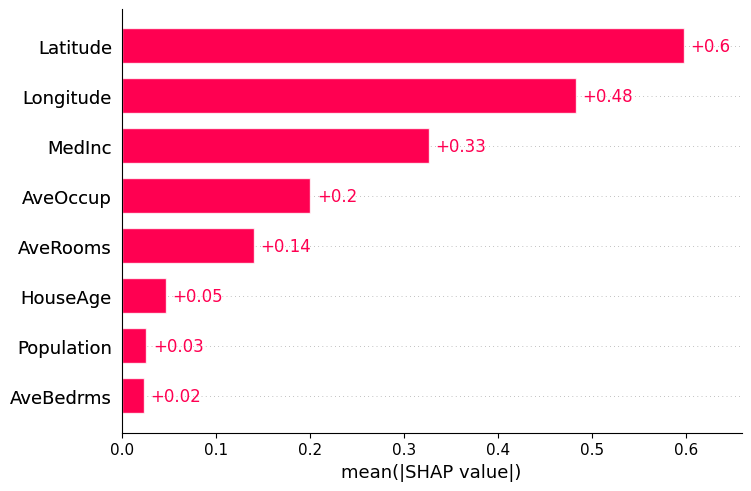

In [31]:
# bar plot to plot feature importance

shap.plots.bar(shap_values)

In [32]:
shap_values.abs.mean(axis=0)

.values =
array([0.32683148, 0.0468913 , 0.14051529, 0.0233901 , 0.02617651,
       0.2007082 , 0.59803868, 0.48282591])

.base_values =
np.float64(2.006915599965246)

.data =
array([3.83033798e+00, 2.87642926e+01, 5.40405863e+00, 1.09663675e+00,
       1.42157171e+03, 2.96543102e+00, 3.55867103e+01, 1.19519360e+02])

In [33]:
shap_values.abs.mean(axis=0).values

array([0.32683148, 0.0468913 , 0.14051529, 0.0233901 , 0.02617651,
       0.2007082 , 0.59803868, 0.48282591])

In [34]:
dict(zip(feature_names,shap_values.abs.mean(axis=0).values))

{'MedInc': np.float64(0.32683148038535054),
 'HouseAge': np.float64(0.04689129951525424),
 'AveRooms': np.float64(0.14051528510343556),
 'AveBedrms': np.float64(0.023390095168660634),
 'Population': np.float64(0.026176510613524193),
 'AveOccup': np.float64(0.20070819681016075),
 'Latitude': np.float64(0.5980386763742565),
 'Longitude': np.float64(0.48282590952202753)}

In [35]:
feature_importances = {feature:shap_val.item() for feature, shap_val in 
                    zip(feature_names,shap_values.abs.mean(axis=0).values)}

In [36]:
feature_importances

{'MedInc': 0.32683148038535054,
 'HouseAge': 0.04689129951525424,
 'AveRooms': 0.14051528510343556,
 'AveBedrms': 0.023390095168660634,
 'Population': 0.026176510613524193,
 'AveOccup': 0.20070819681016075,
 'Latitude': 0.5980386763742565,
 'Longitude': 0.48282590952202753}

In [37]:
sorted(feature_importances, key=feature_importances.get, reverse=True)

['Latitude',
 'Longitude',
 'MedInc',
 'AveOccup',
 'AveRooms',
 'HouseAge',
 'Population',
 'AveBedrms']

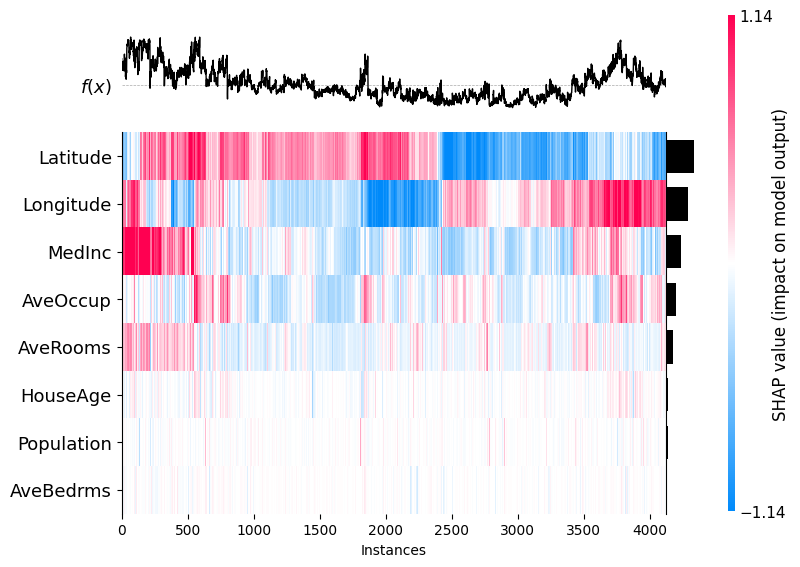

<Axes: xlabel='Instances'>

In [38]:
# heatmap plot

shap.plots.heatmap(shap_values)

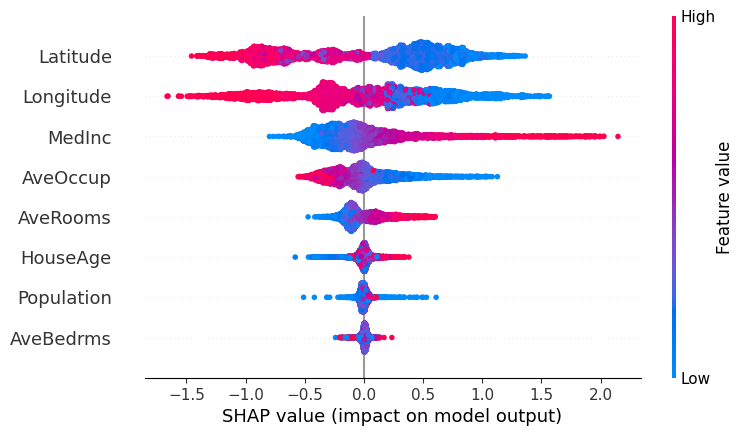

In [39]:
# summary plot

shap.plots.beeswarm(shap_values)

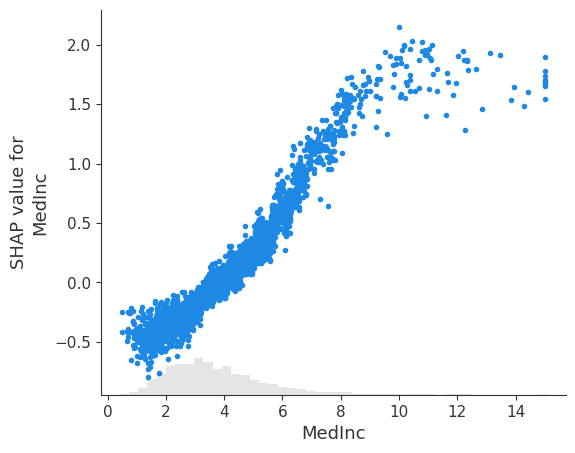

In [40]:
# scatter plot (Dependence Plot)
shap.plots.scatter(shap_values[:, "MedInc"])

In [41]:
shap_values[:, "Latitude"]

.values =
array([-0.6966287 , -0.69259674,  0.22359704, ..., -0.02329341,
       -0.97866729,  0.22632911], shape=(4128,))

.base_values =
array([2.0069156, 2.0069156, 2.0069156, ..., 2.0069156, 2.0069156,
       2.0069156], shape=(4128,))

.data =
array([36.06, 35.14, 37.8 , ..., 37.31, 36.77, 34.22], shape=(4128,))

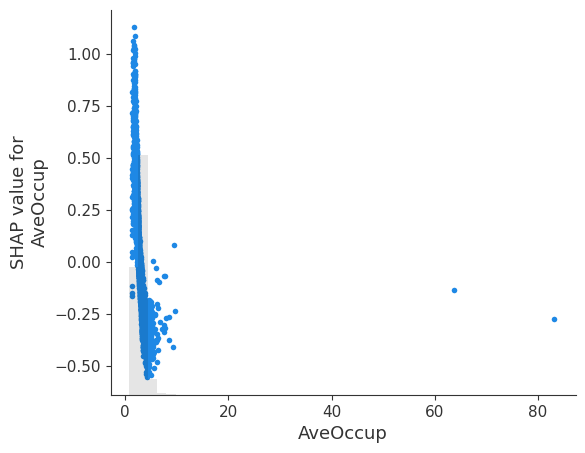

In [42]:
shap.plots.scatter(shap_values[:, "AveOccup"])

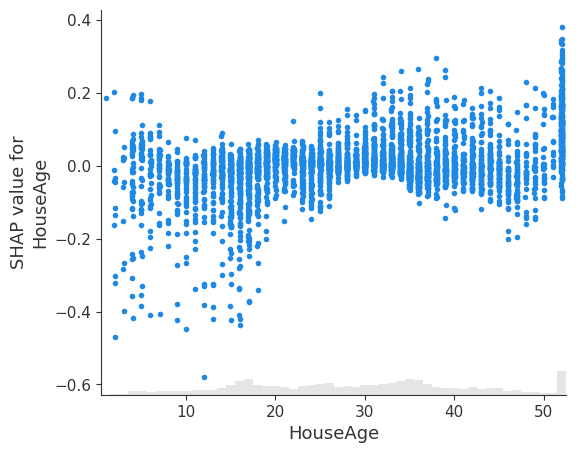

In [43]:
shap.plots.scatter(shap_values[:, "HouseAge"])

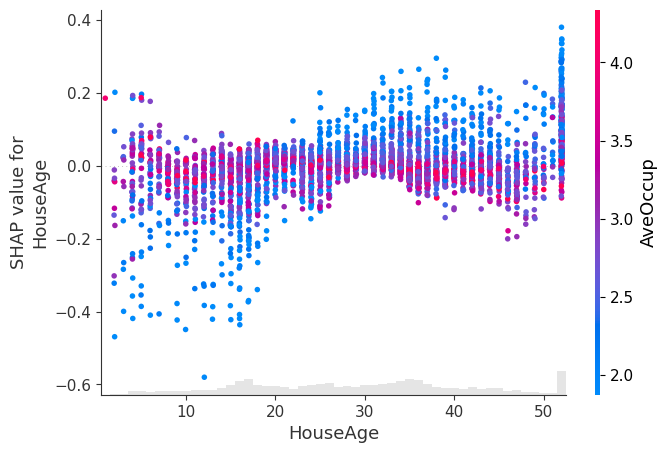

In [44]:
# scatter plot with interaction

shap.plots.scatter(shap_values[:, "HouseAge"], color=shap_values)

### LOCAL PLOTS

In [45]:
test_case = X_test.sample(1)

test_case

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
2771,1.7857,19.0,7.806452,1.6,329.0,2.122581,33.34,-115.9


In [46]:
explained_row = explainer(test_case)

explained_row

.values =
array([[-0.50937688, -0.04655107,  0.25240616, -0.0367331 , -0.05185901,
         0.21201143,  0.62877702, -1.56730241]])

.base_values =
array([2.0069156])

.data =
array([[   1.7857    ,   19.        ,    7.80645161,    1.6       ,
         329.        ,    2.12258065,   33.34      , -115.9       ]])

In [47]:
explained_row[0,:].shape

(8,)

In [48]:
explained_row.shape

(1, 8)

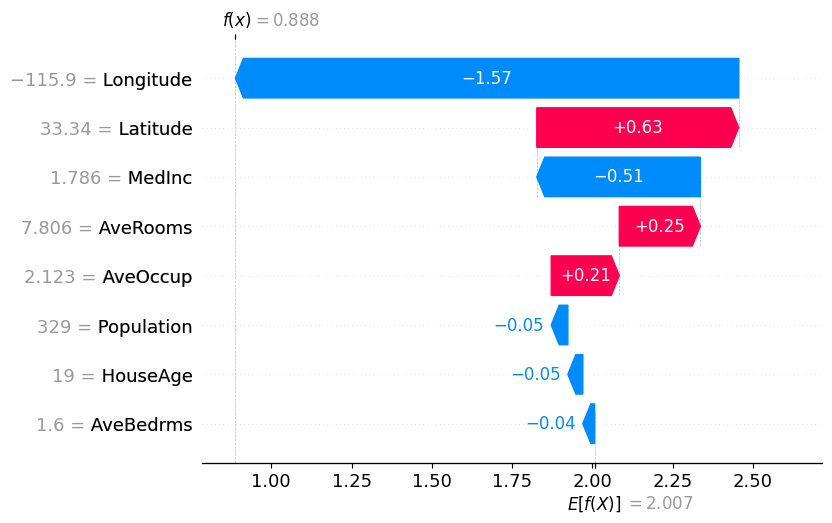

In [49]:
# waterfall plot

shap.plots.waterfall(explained_row[0])

In [50]:
# force plot

shap.plots.initjs()

shap.plots.force(explained_row[0])

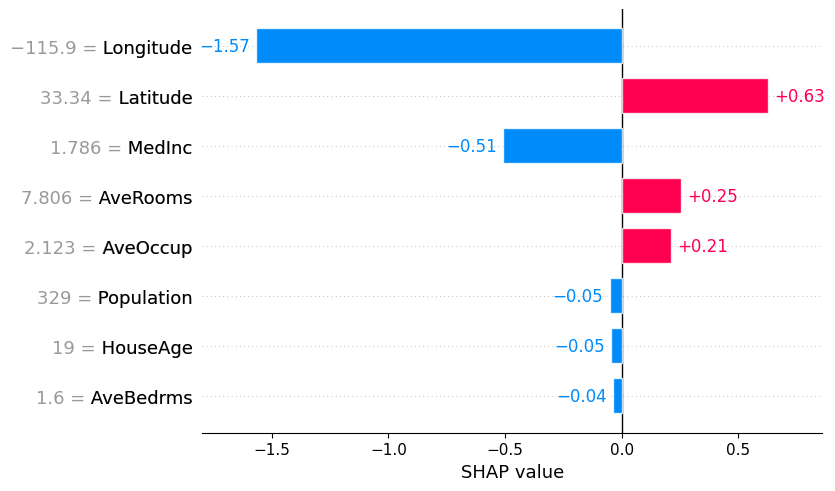

In [51]:
# bar plot for local explaination

shap.plots.bar(explained_row[0])

## LIME

In [93]:
# test case

test_case

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
2771,1.7857,19.0,7.806452,1.6,329.0,2.122581,33.34,-115.9


In [99]:
# convert test case to a 1D array

test_case_lime = test_case.values.flatten()

In [100]:
from lime.lime_tabular import LimeTabularExplainer

In [103]:
X_train.values.shape

(16512, 8)

In [106]:
# feature names

feature_names = X_train.columns.tolist()

In [107]:
# make an lime explainer

lime_explainer = LimeTabularExplainer(
    training_data=X_train.values,
    mode="regression",
    feature_names=feature_names
)

In [108]:
# get the lime explanations

lime_explanation = lime_explainer.explain_instance(
    data_row=test_case_lime,
    predict_fn=xgb_model.predict
)

In [111]:
# lime explanations --> list of values

lime_explanation.as_list()

[('Latitude <= 33.93', 1.0252671421447885),
 ('Longitude > -118.01', -0.9189663599368897),
 ('MedInc <= 2.57', -0.5393349443890234),
 ('AveRooms > 6.06', 0.46133591279389796),
 ('AveOccup <= 2.43', 0.46103665839518226),
 ('Population <= 789.00', 0.005390917590129793),
 ('18.00 < HouseAge <= 29.00', 0.003680800733037336),
 ('AveBedrms > 1.10', 0.0004507749336905381)]

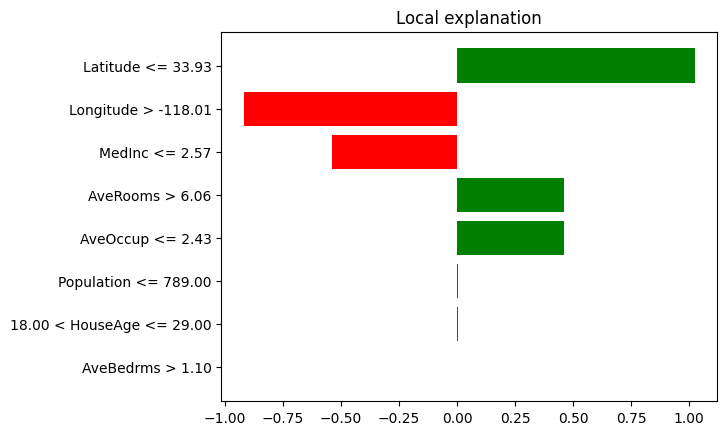

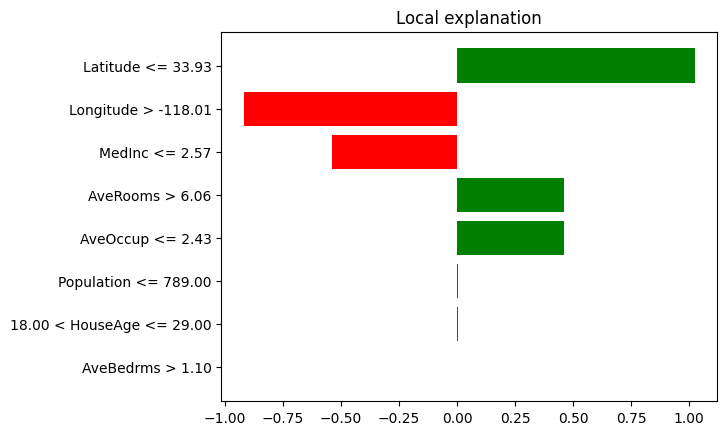

In [110]:
# lime explanations --> pyplot figure

lime_explanation.as_pyplot_figure()

In [112]:
# lime explanations --> as html

from IPython.core.display import HTML

In [114]:
xgb_model.predict(test_case)

array([0.9001361], dtype=float32)

In [113]:
# display explanation

display(HTML(lime_explanation.as_html()))